In [1]:
import pandas as pd
import numpy as np

from data_preprocess import read_raw_data

from matplotlib import pylab as plt
%matplotlib inline

In [2]:
raw_data = read_raw_data("./Train_Транзакции_отток v2.xlsx")
raw_data.head(10)

client_id       date      time   mcc  target   amount         category
0          8 2017-03-03  16:02:11  4722       0  5541.51           Hotels
1          8 2017-03-03  16:35:54  4511       0  7018.00          Flights
2          8 2017-03-04  07:29:43  7011       0  3389.80           Hotels
3          8 2017-03-27  13:21:52  7997       0  6300.00    Entertainment
4          8 2017-03-27  13:29:48  5651       0    80.00          Clothes
5          8 2017-03-29  13:20:19  5411       0   620.11     Supermarkets
6          8 2017-03-29  18:14:35  5921       0   187.95  Alcohol_tobacco
7          8 2017-03-29  18:16:18  5921       0     2.99  Alcohol_tobacco
8          8 2017-03-30  12:54:40  5411       0   696.97     Supermarkets
9          8 2017-03-31  13:02:04  5411       0   617.65     Supermarkets

# Data Imbalance

In [3]:
from collections import Counter

count_per_class = Counter()
for client_id, group in raw_data.groupby("client_id"):
    count_per_class[group.target.values[0]] += 1

n_clients = sum(count_per_class.values())
print("Clients count: %d" % n_clients)
print("Non-churners count: %d, which is %.3f%%" % (count_per_class[0], count_per_class[0] / n_clients))
print("Churners count: %d, which is %.3f%%" % (count_per_class[1], count_per_class[1] / n_clients))

Clients count: 7426
Non-churners count: 5190, which is 0.699%
Churners count: 2236, which is 0.301%


# 1. Per-month amount-only approach

Для каждого пользователя определим 3 месяца активности, для которых, в свою очередь, определим признаки вида: category_i, где category -- тип категории трат, а i -- номер месяца (1, 2, 3), в котором траты были произведены. Каждый признак такого вида означает суммарные траты по данной категории в этом месяце.

In [374]:
def determine_months_range(group):
    unique_months = [*set(group.date.apply(lambda x: x.month).values)]
    n_months = len(unique_months)
    if n_months > 3:
        unique_months.sort()
        unique_months = unique_months[1:]
    if n_months < 3:
        min_month = min(unique_months)
        unique_months += [min_month - i - 1 for i in range(3 - n_months)]
    return unique_months


def extract_features(raw_data):
    from collections import defaultdict
    
    features = []
    for client_id, group in raw_data.groupby("client_id"):
        target = group.target.iloc[0]
        
        months_range = determine_months_range(group)
        transactions_data = {k: defaultdict(lambda: 0) for k in months_range}
        for date, amount, category in zip(group.date, group.amount, group.category):
            month = date.month
            if month not in months_range:
                continue
            transactions_data[month][category] += amount
            transactions_data[month]["total_amount"] += amount
            transactions_data[month]["transactions_count"] += 1
            if type(transactions_data[month]["mean_amount"]) is int:
                transactions_data[month]["mean_amount"] = []
            transactions_data[month]["mean_amount"].append(amount)
        months_range.sort()
        for i, month in enumerate(months_range):
            transactions_data[month]["mean_amount"] = np.mean(transactions_data[month]["mean_amount"])
            if i > 0:
                prev_month = months_range[i - 1]
                #transactions_data[month]["Supermarkets_prev_diff"] =\
                #    transactions_data[month]["Supermarkets"] - transactions_data[prev_month]["Supermarkets"]
                transactions_data[month]["prev_mean_amount_diff"] =\
                    transactions_data[month]["mean_amount"] - transactions_data[prev_month]["mean_amount"]
        
        data = {
            "transactions": {i: transactions_data[k] for i, k in enumerate(sorted(transactions_data.keys()))}
        }
        features.append({"client_id": client_id, "data": data, "target": target})
    return features


def normalize_features(per_client_features):
    from collections import defaultdict
    
    per_client_features = per_client_features.copy()
    
    # normalize transactions data
    # 1st run: collect data
    transactions_vals = defaultdict(lambda: defaultdict(lambda: []))
    for client_features in per_client_features:
        transactions_data = client_features["data"]["transactions"]
        for month, categories in transactions_data.items():
            for category, amount in categories.items():
                transactions_vals[month][category].append(amount)
    # 2nd run: normalize features
    means = defaultdict(lambda: defaultdict(lambda: 0))
    stds = defaultdict(lambda: defaultdict(lambda: 0))
    for client_features in per_client_features:
        transactions_data = client_features["data"]["transactions"]
        for month in transactions_data.keys():
            for category in transactions_data[month].keys():
                if month not in means or category not in means[month]:
                    means[month][category] = np.mean(transactions_vals[month][category])
                    stds[month][category] = np.std(transactions_vals[month][category])
                    
                if stds[month][category] > 1e-5:
                    transactions_data[month][category] -= means[month][category]
                    transactions_data[month][category] /= stds[month][category]
                else:
                    transactions_data[month][category] /= means[month][category]
    return per_client_features

In [375]:
features = extract_features(raw_data)
#features = normalize_features(features)

### 1.1 VW

In [6]:
def features_to_vw(features, filename):
    with open(filename, "wt") as f:
        for client_data in features:
            label = -1 if client_data["target"] == 0 else 1
            data_str = "%d |" % label
            for i, month in enumerate(client_data["data"]["transactions"].keys()):
                for category, amount in client_data["data"]["transactions"][month].items():
                    data_str += " %s_%d:%g" % (category, i, amount)
            data_str += "\n"
            f.write(data_str)

Сделаем train-test разбиение.

In [7]:
def train_test_split(features, test_percent=0.05, random_state=42):
    from collections import defaultdict
    import numpy as np
    
    np.random.seed(42)
    
    classes = defaultdict(lambda: [])
    for client_data in features:
        classes[client_data["target"]].append(client_data)
    
    np.random.shuffle(classes[0])
    np.random.shuffle(classes[1])
    
    train, test = [], []
    for target in range(2):
        test_size = int(np.ceil(len(classes[target]) * test_percent))
        test += classes[target][:test_size]
        train += classes[target][test_size:]
    
    np.random.shuffle(train)
    np.random.shuffle(test)
    
    return train, test

In [8]:
train, test = train_test_split(features, test_percent=0.1)
features_to_vw(train, "approach_1_1_train.vw")
features_to_vw(test, "approach_1_1_test.vw")

Протестируем.

In [9]:
n_passes = 100
lr_decay = 1
ngram = 2
power_t = 0
l1 = 1e-7
l2 = 1e-7

! vw --quiet --random_seed 42 --data approach_1_1_train.vw -c --decay_learning_rate $lr_decay --leave_duplicate_interactions --passes $n_passes --ngram $ngram --l2 $l2 --l1 $l1 --power_t $power_t --holdout_off --loss_function hinge -f approach_1_1_model_vw
! vw --quiet --leave_duplicate_interactions -i approach_1_1_model_vw -t approach_1_1_test.vw -p approach_1_1_predictions.txt --binary

In [10]:
truth = {"total": 0, 0: 0, 1: 0}

with open("approach_1_1_predictions.txt", "rt") as f:
    for i, x in enumerate(f):
        x = float(x)
        x = 0 if x <= 0 else 1
        inc = 1 if test[i]["target"] == x else 0
        truth["total"] += inc
        truth[test[i]["target"]] += inc

truth["total"] /= len(test)
truth[0] /= sum([1 for x in test if x["target"] == 0])
truth[1] /= sum([1 for x in test if x["target"] == 1])

truth

{'total': 0.6500672947510094, 0: 0.8265895953757225, 1: 0.24107142857142858}

# Clustering

In [151]:
def as_dense_matrix(features):
    # build a dictionary of indices
    y = np.ndarray(len(features), dtype="int8")
    feature_keys = {}
    for i, f in enumerate(features):
        transactions = f["data"]["transactions"]
        y[i] = f["target"]
        for month, categories in transactions.items():
            for category in categories.keys():
                new_key = (month, category)
                if new_key not in feature_keys:
                    feature_keys[new_key] = len(feature_keys)
    
    # build a dense matrix
    X = np.zeros(shape=(len(features), len(feature_keys)))
    feature_names = [0 for _ in feature_keys]
    for i, f in enumerate(features):
        transactions = f["data"]["transactions"]
        for month, categories in transactions.items():
            for category, value in categories.items():
                key = (month, category)
                feature_names[feature_keys[key]] = "%s_%d" % (category, month)
                X[i, feature_keys[key]] = value
                
    return X, y, np.array(feature_names)

In [215]:
X, y, feature_names = as_dense_matrix(features)

In [211]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=42)

X_reduced = tsne.fit_transform(X)

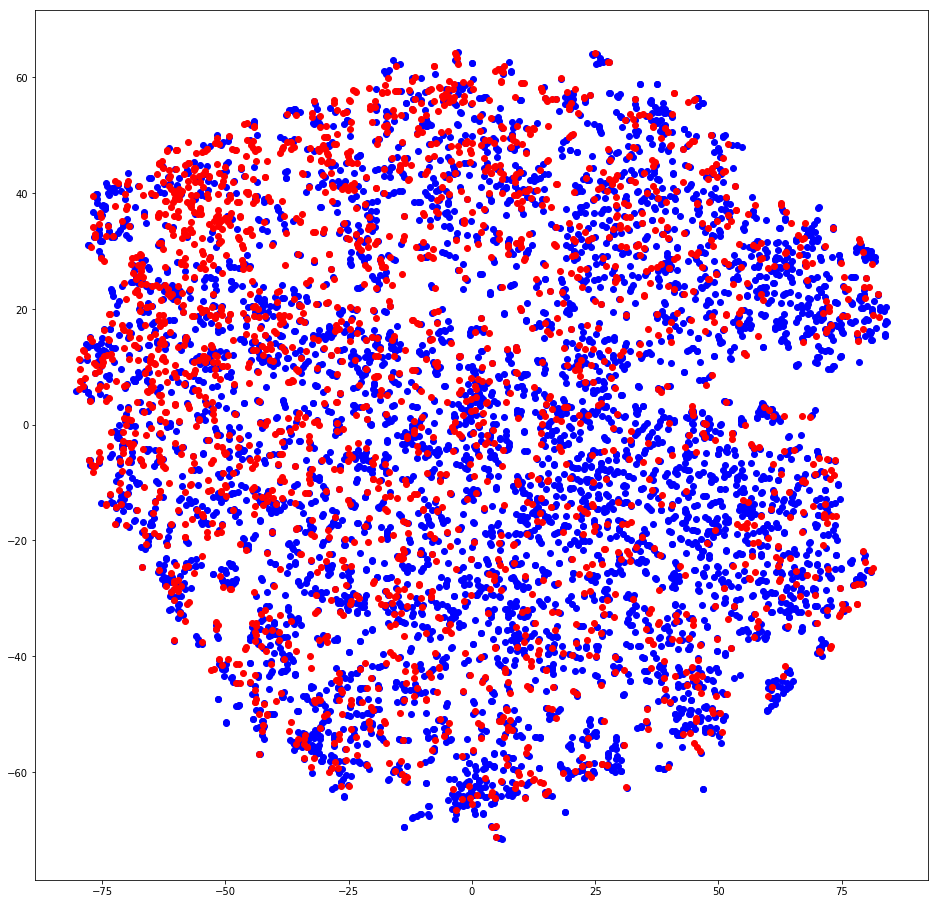

In [212]:
plt.figure(figsize=(16, 16))
plt.scatter(X_reduced[y == 0, 0], X_reduced[y == 0, 1], c="blue")
plt.scatter(X_reduced[y == 1, 0], X_reduced[y == 1, 1], c="red")

# Dense  Matrix Approach

In [305]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool

In [563]:
X, y, feature_names = as_dense_matrix(features)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [564]:
weights = np.zeros(y_train.size)
weights[y_train == 0] = 1 - y_train.sum() / y_train.shape
weights[y_train == 1] = y_train.sum() / y_train.shape

#weights = np.zeros(y_train_u.size)
#weights[y_train_u == 0] = 1 - y_train_u.sum() / y_train_u.shape
#weights[y_train_u == 1] = y_train_u.sum() / y_train_u.shape

#train_pool = Pool(X_train_u, label=y_train_u, thread_count=4, weight=weights)
#test_pool = Pool(X_test, label=y_test, thread_count=4)

train_pool = Pool(X_train, label=y_train, thread_count=4, weight=weights)
test_pool = Pool(X_test, label=y_test, thread_count=4)

#train_pool = Pool(X_train[:, importance >= 0.05], label=y_train, thread_count=4)
#test_pool = Pool(X_test[:, importance >= 0.05], label=y_test, thread_count=4)

In [571]:
clf = CatBoostClassifier(iterations=1000, depth=5, loss_function='Logloss', learning_rate=0.03,
                         custom_metric="AUC", eval_metric="AUC",
                         verbose=True, random_seed=42).fit(train_pool, eval_set=test_pool)

0:	learn: 0.5505333	test: 0.5504512	best: 0.5504512 (0)	total: 48.1ms	remaining: 48.1s
1:	learn: 0.5791782	test: 0.5876708	best: 0.5876708 (1)	total: 104ms	remaining: 51.8s
2:	learn: 0.6240432	test: 0.6074186	best: 0.6074186 (2)	total: 149ms	remaining: 49.4s
3:	learn: 0.6260650	test: 0.5980898	best: 0.6074186 (2)	total: 191ms	remaining: 47.5s
4:	learn: 0.6267695	test: 0.5951200	best: 0.6074186 (2)	total: 235ms	remaining: 46.8s
5:	learn: 0.6275502	test: 0.5956086	best: 0.6074186 (2)	total: 298ms	remaining: 49.3s
6:	learn: 0.6277341	test: 0.5943805	best: 0.6074186 (2)	total: 342ms	remaining: 48.5s
7:	learn: 0.6297254	test: 0.6018068	best: 0.6074186 (2)	total: 385ms	remaining: 47.8s
8:	learn: 0.6366102	test: 0.6148085	best: 0.6148085 (8)	total: 427ms	remaining: 47s
9:	learn: 0.6382023	test: 0.6161899	best: 0.6161899 (9)	total: 478ms	remaining: 47.3s
10:	learn: 0.6393864	test: 0.6153181	best: 0.6161899 (9)	total: 540ms	remaining: 48.6s
11:	learn: 0.6397450	test: 0.6171038	best: 0.6171038 (

95:	learn: 0.6483283	test: 0.6255858	best: 0.6258770 (94)	total: 4.48s	remaining: 42.2s
96:	learn: 0.6483448	test: 0.6257161	best: 0.6258770 (94)	total: 4.52s	remaining: 42.1s
97:	learn: 0.6484251	test: 0.6255666	best: 0.6258770 (94)	total: 4.57s	remaining: 42s
98:	learn: 0.6485068	test: 0.6257697	best: 0.6258770 (94)	total: 4.61s	remaining: 42s
99:	learn: 0.6485824	test: 0.6252869	best: 0.6258770 (94)	total: 4.65s	remaining: 41.9s
100:	learn: 0.6487198	test: 0.6255437	best: 0.6258770 (94)	total: 4.71s	remaining: 41.9s
101:	learn: 0.6487757	test: 0.6250877	best: 0.6258770 (94)	total: 4.75s	remaining: 41.8s
102:	learn: 0.6493751	test: 0.6257467	best: 0.6258770 (94)	total: 4.8s	remaining: 41.8s
103:	learn: 0.6495445	test: 0.6256241	best: 0.6258770 (94)	total: 4.84s	remaining: 41.7s
104:	learn: 0.6495877	test: 0.6257314	best: 0.6258770 (94)	total: 4.89s	remaining: 41.7s
105:	learn: 0.6497560	test: 0.6256931	best: 0.6258770 (94)	total: 4.94s	remaining: 41.7s
106:	learn: 0.6498584	test: 0.6

188:	learn: 0.6554715	test: 0.6227004	best: 0.6258770 (94)	total: 8.64s	remaining: 37.1s
189:	learn: 0.6555597	test: 0.6227617	best: 0.6258770 (94)	total: 8.69s	remaining: 37s
190:	learn: 0.6555754	test: 0.6227923	best: 0.6258770 (94)	total: 8.73s	remaining: 37s
191:	learn: 0.6555977	test: 0.6228805	best: 0.6258770 (94)	total: 8.77s	remaining: 36.9s
192:	learn: 0.6556016	test: 0.6228805	best: 0.6258770 (94)	total: 8.8s	remaining: 36.8s
193:	learn: 0.6556420	test: 0.6228805	best: 0.6258770 (94)	total: 8.84s	remaining: 36.7s
194:	learn: 0.6556420	test: 0.6228843	best: 0.6258770 (94)	total: 8.88s	remaining: 36.6s
195:	learn: 0.6556748	test: 0.6228077	best: 0.6258770 (94)	total: 8.92s	remaining: 36.6s
196:	learn: 0.6558132	test: 0.6227578	best: 0.6258770 (94)	total: 8.97s	remaining: 36.5s
197:	learn: 0.6558508	test: 0.6227463	best: 0.6258770 (94)	total: 9.01s	remaining: 36.5s
198:	learn: 0.6559029	test: 0.6227234	best: 0.6258770 (94)	total: 9.05s	remaining: 36.4s
199:	learn: 0.6559573	test

286:	learn: 0.6577311	test: 0.6213285	best: 0.6258770 (94)	total: 13s	remaining: 32.2s
287:	learn: 0.6576964	test: 0.6213285	best: 0.6258770 (94)	total: 13s	remaining: 32.1s
288:	learn: 0.6576884	test: 0.6212404	best: 0.6258770 (94)	total: 13s	remaining: 32.1s
289:	learn: 0.6577230	test: 0.6212366	best: 0.6258770 (94)	total: 13.1s	remaining: 32s
290:	learn: 0.6577168	test: 0.6211753	best: 0.6258770 (94)	total: 13.1s	remaining: 32s
291:	learn: 0.6577277	test: 0.6211408	best: 0.6258770 (94)	total: 13.2s	remaining: 31.9s
292:	learn: 0.6577298	test: 0.6211446	best: 0.6258770 (94)	total: 13.2s	remaining: 31.9s
293:	learn: 0.6577209	test: 0.6209990	best: 0.6258770 (94)	total: 13.3s	remaining: 31.9s
294:	learn: 0.6577011	test: 0.6210028	best: 0.6258770 (94)	total: 13.3s	remaining: 31.8s
295:	learn: 0.6577372	test: 0.6210143	best: 0.6258770 (94)	total: 13.3s	remaining: 31.7s
296:	learn: 0.6577136	test: 0.6209568	best: 0.6258770 (94)	total: 13.4s	remaining: 31.7s
297:	learn: 0.6577711	test: 0.6

381:	learn: 0.7066315	test: 0.6613071	best: 0.6615063 (378)	total: 17.3s	remaining: 28s
382:	learn: 0.7068893	test: 0.6613147	best: 0.6615063 (378)	total: 17.4s	remaining: 27.9s
383:	learn: 0.7073771	test: 0.6617822	best: 0.6617822 (383)	total: 17.4s	remaining: 27.9s
384:	learn: 0.7078322	test: 0.6620658	best: 0.6620658 (384)	total: 17.4s	remaining: 27.9s
385:	learn: 0.7083261	test: 0.6624643	best: 0.6624643 (385)	total: 17.5s	remaining: 27.8s
386:	learn: 0.7087738	test: 0.6627747	best: 0.6627747 (386)	total: 17.5s	remaining: 27.8s
387:	learn: 0.7089414	test: 0.6630698	best: 0.6630698 (387)	total: 17.6s	remaining: 27.8s
388:	learn: 0.7091559	test: 0.6635104	best: 0.6635104 (388)	total: 17.6s	remaining: 27.7s
389:	learn: 0.7094492	test: 0.6634721	best: 0.6635104 (388)	total: 17.7s	remaining: 27.7s
390:	learn: 0.7098443	test: 0.6636139	best: 0.6636139 (390)	total: 17.7s	remaining: 27.6s
391:	learn: 0.7101546	test: 0.6637403	best: 0.6637403 (391)	total: 17.8s	remaining: 27.6s
392:	learn: 

476:	learn: 0.7395459	test: 0.6714080	best: 0.6714080 (476)	total: 21.7s	remaining: 23.8s
477:	learn: 0.7397792	test: 0.6715038	best: 0.6715038 (477)	total: 21.8s	remaining: 23.8s
478:	learn: 0.7399902	test: 0.6712624	best: 0.6715038 (477)	total: 21.8s	remaining: 23.7s
479:	learn: 0.7402671	test: 0.6715422	best: 0.6715422 (479)	total: 21.8s	remaining: 23.7s
480:	learn: 0.7404843	test: 0.6716303	best: 0.6716303 (480)	total: 21.9s	remaining: 23.6s
481:	learn: 0.7406287	test: 0.6715881	best: 0.6716303 (480)	total: 21.9s	remaining: 23.6s
482:	learn: 0.7408522	test: 0.6713927	best: 0.6716303 (480)	total: 22s	remaining: 23.5s
483:	learn: 0.7410370	test: 0.6713544	best: 0.6716303 (480)	total: 22s	remaining: 23.5s
484:	learn: 0.7411390	test: 0.6717721	best: 0.6717721 (484)	total: 22.1s	remaining: 23.4s
485:	learn: 0.7413362	test: 0.6719637	best: 0.6719637 (485)	total: 22.1s	remaining: 23.4s
486:	learn: 0.7415318	test: 0.6720441	best: 0.6720441 (486)	total: 22.2s	remaining: 23.3s
487:	learn: 0.

571:	learn: 0.7613869	test: 0.6736267	best: 0.6751135 (537)	total: 26.1s	remaining: 19.5s
572:	learn: 0.7614642	test: 0.6736957	best: 0.6751135 (537)	total: 26.1s	remaining: 19.5s
573:	learn: 0.7616500	test: 0.6739371	best: 0.6751135 (537)	total: 26.2s	remaining: 19.4s
574:	learn: 0.7619498	test: 0.6738681	best: 0.6751135 (537)	total: 26.2s	remaining: 19.4s
575:	learn: 0.7621075	test: 0.6738988	best: 0.6751135 (537)	total: 26.3s	remaining: 19.3s
576:	learn: 0.7623414	test: 0.6740061	best: 0.6751135 (537)	total: 26.3s	remaining: 19.3s
577:	learn: 0.7625883	test: 0.6742820	best: 0.6751135 (537)	total: 26.4s	remaining: 19.3s
578:	learn: 0.7626820	test: 0.6742245	best: 0.6751135 (537)	total: 26.4s	remaining: 19.2s
579:	learn: 0.7628055	test: 0.6743969	best: 0.6751135 (537)	total: 26.5s	remaining: 19.2s
580:	learn: 0.7629276	test: 0.6744046	best: 0.6751135 (537)	total: 26.5s	remaining: 19.1s
581:	learn: 0.7631663	test: 0.6744276	best: 0.6751135 (537)	total: 26.6s	remaining: 19.1s
582:	learn

666:	learn: 0.7787089	test: 0.6748261	best: 0.6759719 (618)	total: 30.5s	remaining: 15.2s
667:	learn: 0.7788288	test: 0.6747380	best: 0.6759719 (618)	total: 30.5s	remaining: 15.2s
668:	learn: 0.7789759	test: 0.6747993	best: 0.6759719 (618)	total: 30.6s	remaining: 15.1s
669:	learn: 0.7790860	test: 0.6748759	best: 0.6759719 (618)	total: 30.6s	remaining: 15.1s
670:	learn: 0.7791909	test: 0.6749449	best: 0.6759719 (618)	total: 30.7s	remaining: 15s
671:	learn: 0.7793731	test: 0.6749641	best: 0.6759719 (618)	total: 30.7s	remaining: 15s
672:	learn: 0.7793812	test: 0.6747648	best: 0.6759719 (618)	total: 30.8s	remaining: 14.9s
673:	learn: 0.7795775	test: 0.6751174	best: 0.6759719 (618)	total: 30.8s	remaining: 14.9s
674:	learn: 0.7796803	test: 0.6750177	best: 0.6759719 (618)	total: 30.9s	remaining: 14.9s
675:	learn: 0.7796620	test: 0.6748951	best: 0.6759719 (618)	total: 30.9s	remaining: 14.8s
676:	learn: 0.7800462	test: 0.6747418	best: 0.6759719 (618)	total: 30.9s	remaining: 14.8s
677:	learn: 0.

761:	learn: 0.7927555	test: 0.6740559	best: 0.6759719 (618)	total: 34.9s	remaining: 10.9s
762:	learn: 0.7929595	test: 0.6740061	best: 0.6759719 (618)	total: 34.9s	remaining: 10.8s
763:	learn: 0.7930767	test: 0.6740444	best: 0.6759719 (618)	total: 35s	remaining: 10.8s
764:	learn: 0.7932580	test: 0.6741019	best: 0.6759719 (618)	total: 35s	remaining: 10.8s
765:	learn: 0.7933362	test: 0.6741862	best: 0.6759719 (618)	total: 35s	remaining: 10.7s
766:	learn: 0.7934759	test: 0.6743126	best: 0.6759719 (618)	total: 35.1s	remaining: 10.7s
767:	learn: 0.7935334	test: 0.6741977	best: 0.6759719 (618)	total: 35.1s	remaining: 10.6s
768:	learn: 0.7937524	test: 0.6741211	best: 0.6759719 (618)	total: 35.2s	remaining: 10.6s
769:	learn: 0.7938717	test: 0.6740827	best: 0.6759719 (618)	total: 35.2s	remaining: 10.5s
770:	learn: 0.7941542	test: 0.6740061	best: 0.6759719 (618)	total: 35.3s	remaining: 10.5s
771:	learn: 0.7942589	test: 0.6738835	best: 0.6759719 (618)	total: 35.3s	remaining: 10.4s
772:	learn: 0.79

856:	learn: 0.8067915	test: 0.6749871	best: 0.6759719 (618)	total: 39.3s	remaining: 6.55s
857:	learn: 0.8070157	test: 0.6749411	best: 0.6759719 (618)	total: 39.3s	remaining: 6.51s
858:	learn: 0.8071608	test: 0.6749947	best: 0.6759719 (618)	total: 39.4s	remaining: 6.46s
859:	learn: 0.8073681	test: 0.6750254	best: 0.6759719 (618)	total: 39.4s	remaining: 6.42s
860:	learn: 0.8074093	test: 0.6749181	best: 0.6759719 (618)	total: 39.5s	remaining: 6.37s
861:	learn: 0.8076788	test: 0.6747495	best: 0.6759719 (618)	total: 39.5s	remaining: 6.32s
862:	learn: 0.8077395	test: 0.6749296	best: 0.6759719 (618)	total: 39.5s	remaining: 6.28s
863:	learn: 0.8078362	test: 0.6749832	best: 0.6759719 (618)	total: 39.6s	remaining: 6.23s
864:	learn: 0.8079967	test: 0.6748644	best: 0.6759719 (618)	total: 39.6s	remaining: 6.18s
865:	learn: 0.8080291	test: 0.6750024	best: 0.6759719 (618)	total: 39.7s	remaining: 6.14s
866:	learn: 0.8082609	test: 0.6748798	best: 0.6759719 (618)	total: 39.7s	remaining: 6.09s
867:	learn

951:	learn: 0.8189015	test: 0.6744889	best: 0.6759719 (618)	total: 43.6s	remaining: 2.2s
952:	learn: 0.8190512	test: 0.6744391	best: 0.6759719 (618)	total: 43.7s	remaining: 2.15s
953:	learn: 0.8191232	test: 0.6743395	best: 0.6759719 (618)	total: 43.7s	remaining: 2.11s
954:	learn: 0.8192069	test: 0.6744314	best: 0.6759719 (618)	total: 43.8s	remaining: 2.06s
955:	learn: 0.8193578	test: 0.6747073	best: 0.6759719 (618)	total: 43.8s	remaining: 2.02s
956:	learn: 0.8194608	test: 0.6748798	best: 0.6759719 (618)	total: 43.9s	remaining: 1.97s
957:	learn: 0.8195917	test: 0.6747150	best: 0.6759719 (618)	total: 43.9s	remaining: 1.93s
958:	learn: 0.8196190	test: 0.6746422	best: 0.6759719 (618)	total: 44s	remaining: 1.88s
959:	learn: 0.8197709	test: 0.6745617	best: 0.6759719 (618)	total: 44s	remaining: 1.83s
960:	learn: 0.8199636	test: 0.6744659	best: 0.6759719 (618)	total: 44.1s	remaining: 1.79s
961:	learn: 0.8200985	test: 0.6744966	best: 0.6759719 (618)	total: 44.1s	remaining: 1.74s
962:	learn: 0.8

In [379]:
feature_names[np.argmax(clf.get_feature_importance(train_pool))]

'mean_amount_2'

In [380]:
importance = np.array(clf.get_feature_importance(train_pool))
sorted(list(zip(feature_names, importance)), key=lambda x: x[1], reverse=True)

[('mean_amount_2', 4.67097302852412),
 ('Supermarkets_1', 4.5288864704630365),
 ('total_amount_2', 3.853365690766471),
 ('total_amount_1', 3.617161264774348),
 ('Restaurants_2', 3.6096169123505293),
 ('Supermarkets_0', 3.58799785729602),
 ('Specialty_food_2', 3.480210991464461),
 ('Specialty_food_0', 3.4094930666137717),
 ('prev_mean_amount_diff_1', 3.3462514767883964),
 ('transactions_count_0', 3.258803711570383),
 ('Supermarkets_2', 3.02766335598146),
 ('Restaurants_1', 2.878781154066608),
 ('Specialty_food_1', 2.783395935244518),
 ('prev_mean_amount_diff_2', 2.6817794687619085),
 ('Pharmacies_2', 2.286556084764498),
 ('transactions_count_1', 2.2611116538438876),
 ('Restaurants_0', 2.187036938575927),
 ('Auto_services_2', 2.174132227790477),
 ('Alcohol_tobacco_0', 2.1211718080667032),
 ('mean_amount_0', 1.8321216260656363),
 ('transactions_count_2', 1.652536349008291),
 ('mean_amount_1', 1.6115299564331182),
 ('Alcohol_tobacco_2', 1.5489835608023468),
 ('total_amount_0', 1.4905103470

# Time Series

In [503]:
import numpy as np
import datetime

def extract_months(group):
    months = sorted([*set(group.date.apply(lambda x: x.month).values)])
    if len(months) > 3:
        months = months[-3:]
    elif len(months) < 3:
        m = months[0]
        diff = 3 - len(months)
        first = list(range(m - diff, m))
        months = first + months
    return months


def extract_year(group):
    return group.date.iloc[0].year


def days_in_month(year, month):
    next_month = datetime.datetime(
                 year + month // 12, month % 12 + 1, 1)
    start_month = datetime.datetime(year, month, 1)
    td = next_month - start_month
    return td.days


def create_time_interval(group):
    months = extract_months(group)
    idxs = []
    for month in months:
        year = extract_year(group)
        n_days = days_in_month(year, month)
        idxs += ["%d-%02d-%02d" % (year, month, day) for day in range(1, n_days + 1)]
    return pd.Series(np.zeros(len(idxs)), index=pd.DatetimeIndex(idxs))


def extract_time_series_for(category):
    series = []
    for client_id, group in raw_data[raw_data.category == category].groupby("client_id"):
        serie = create_time_interval(group)
        dates = group.date.apply(lambda x: str(x.date()))
        proper_months = extract_months(group)
        for date, amount in zip(dates, group.amount):
            if int(date.split("-")[1]) in proper_months:
                serie[date] += amount
        series.append(serie)
    return series

In [504]:
ts = extract_time_series_for("Supermarkets")

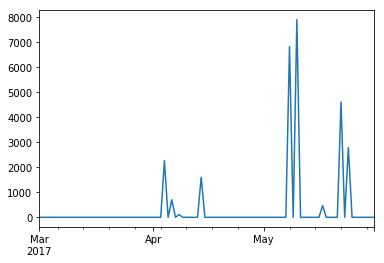

In [483]:
ts[2].plot()

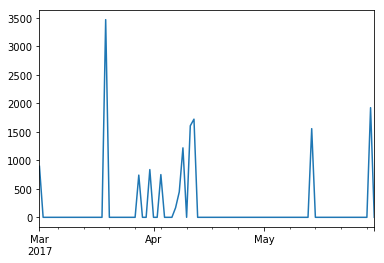

In [489]:
ts[4].plot()

In [367]:
from pandas.plotting import autocorrelation_plot

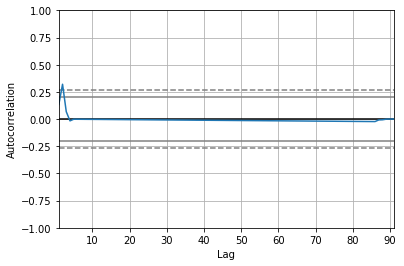

In [490]:
autocorrelation_plot(ts[1])

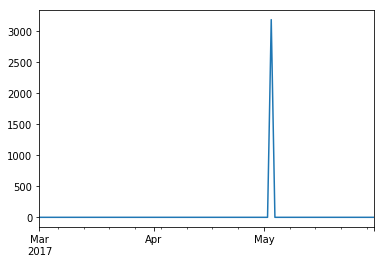

In [496]:
ts[6].plot()

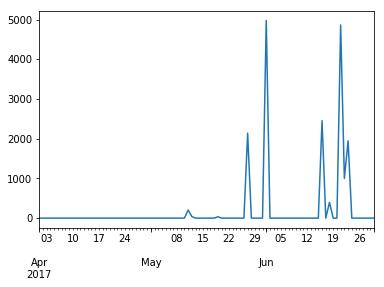

In [500]:
ts[3].plot()

In [498]:
y[:7]

array([0, 1, 0, 1, 0, 1, 0], dtype=int8)

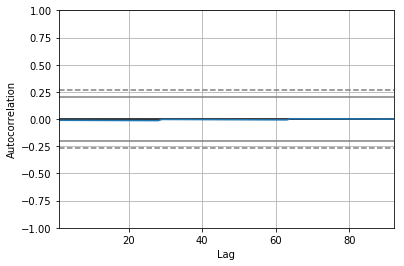

In [519]:
autocorrelation_plot(ts[6])

In [539]:
def add_autocorr_features(X, ts, feature_names, lag_begin, lag_end):
    X_new = np.zeros((X.shape[0], lag_end - lag_begin))
    for i, s in enumerate(ts):
        X_new[i] = np.array([s.autocorr(i + 1) for i in range(lag_begin, lag_end)])
    feature_names = np.hstack([feature_names, ["autocorr_%d" % i for i in range(lag_begin, lag_end)]])
    return np.hstack([X, X_new]), feature_names

In [603]:
X_new, new_features = add_autocorr_features(X, ts, feature_names, 20, 32)
#X_new, new_features = add_autocorr_features(X_new, ts, new_features, 30, 32)

In [604]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.15, random_state=42)

In [605]:
weights = np.zeros(y_train.size)
weights[y_train == 0] = 1 - y_train.sum() / y_train.shape
weights[y_train == 1] = y_train.sum() / y_train.shape

train_pool = Pool(X_train, label=y_train, thread_count=4, weight=weights)
#train_pool = Pool(X_train, label=y_train, thread_count=4)
test_pool = Pool(X_test, label=y_test, thread_count=4)

In [606]:
clf = CatBoostClassifier(iterations=1500, depth=5, loss_function='Logloss', learning_rate=0.03,
                         custom_metric="AUC", eval_metric="AUC",
                         verbose=True, random_seed=42).fit(train_pool, eval_set=test_pool)

0:	learn: 0.5205593	test: 0.4895407	best: 0.4895407 (0)	total: 81.6ms	remaining: 2m 2s
1:	learn: 0.5342072	test: 0.5028184	best: 0.5028184 (1)	total: 133ms	remaining: 1m 39s
2:	learn: 0.5841752	test: 0.5430575	best: 0.5430575 (2)	total: 180ms	remaining: 1m 29s
3:	learn: 0.5914663	test: 0.5399326	best: 0.5430575 (2)	total: 228ms	remaining: 1m 25s
4:	learn: 0.6034224	test: 0.5671891	best: 0.5671891 (4)	total: 278ms	remaining: 1m 23s
5:	learn: 0.6044403	test: 0.5664936	best: 0.5671891 (4)	total: 346ms	remaining: 1m 26s
6:	learn: 0.6063411	test: 0.5692602	best: 0.5692602 (6)	total: 396ms	remaining: 1m 24s
7:	learn: 0.6084396	test: 0.5702738	best: 0.5702738 (7)	total: 446ms	remaining: 1m 23s
8:	learn: 0.6108357	test: 0.5683712	best: 0.5702738 (7)	total: 493ms	remaining: 1m 21s
9:	learn: 0.6116024	test: 0.5661430	best: 0.5702738 (7)	total: 547ms	remaining: 1m 21s
10:	learn: 0.6106143	test: 0.5666526	best: 0.5702738 (7)	total: 611ms	remaining: 1m 22s
11:	learn: 0.6162843	test: 0.5758493	best:

94:	learn: 0.6590069	test: 0.6222597	best: 0.6237503 (61)	total: 5.87s	remaining: 1m 26s
95:	learn: 0.6591165	test: 0.6222137	best: 0.6237503 (61)	total: 5.96s	remaining: 1m 27s
96:	learn: 0.6592690	test: 0.6220489	best: 0.6237503 (61)	total: 6.05s	remaining: 1m 27s
97:	learn: 0.6592921	test: 0.6220643	best: 0.6237503 (61)	total: 6.14s	remaining: 1m 27s
98:	learn: 0.6593778	test: 0.6221639	best: 0.6237503 (61)	total: 6.22s	remaining: 1m 28s
99:	learn: 0.6595587	test: 0.6220413	best: 0.6237503 (61)	total: 6.3s	remaining: 1m 28s
100:	learn: 0.6597050	test: 0.6220374	best: 0.6237503 (61)	total: 6.38s	remaining: 1m 28s
101:	learn: 0.6595610	test: 0.6221984	best: 0.6237503 (61)	total: 6.44s	remaining: 1m 28s
102:	learn: 0.6597331	test: 0.6221217	best: 0.6237503 (61)	total: 6.5s	remaining: 1m 28s
103:	learn: 0.6597189	test: 0.6220566	best: 0.6237503 (61)	total: 6.57s	remaining: 1m 28s
104:	learn: 0.6597092	test: 0.6218650	best: 0.6237503 (61)	total: 6.65s	remaining: 1m 28s
105:	learn: 0.6602

188:	learn: 0.6645880	test: 0.6175656	best: 0.6237503 (61)	total: 12.7s	remaining: 1m 28s
189:	learn: 0.6646304	test: 0.6175119	best: 0.6237503 (61)	total: 12.8s	remaining: 1m 28s
190:	learn: 0.6646214	test: 0.6174200	best: 0.6237503 (61)	total: 12.8s	remaining: 1m 27s
191:	learn: 0.6646241	test: 0.6174813	best: 0.6237503 (61)	total: 12.9s	remaining: 1m 27s
192:	learn: 0.6646530	test: 0.6174813	best: 0.6237503 (61)	total: 13s	remaining: 1m 28s
193:	learn: 0.6646966	test: 0.6174813	best: 0.6237503 (61)	total: 13.1s	remaining: 1m 28s
194:	learn: 0.6647713	test: 0.6175234	best: 0.6237503 (61)	total: 13.2s	remaining: 1m 28s
195:	learn: 0.6647769	test: 0.6175234	best: 0.6237503 (61)	total: 13.2s	remaining: 1m 27s
196:	learn: 0.6647986	test: 0.6176269	best: 0.6237503 (61)	total: 13.3s	remaining: 1m 27s
197:	learn: 0.6648790	test: 0.6176269	best: 0.6237503 (61)	total: 13.3s	remaining: 1m 27s
198:	learn: 0.6649564	test: 0.6171287	best: 0.6237503 (61)	total: 13.4s	remaining: 1m 27s
199:	learn: 

282:	learn: 0.6666359	test: 0.6147031	best: 0.6237503 (61)	total: 19.2s	remaining: 1m 22s
283:	learn: 0.6666438	test: 0.6146763	best: 0.6237503 (61)	total: 19.2s	remaining: 1m 22s
284:	learn: 0.6666447	test: 0.6146763	best: 0.6237503 (61)	total: 19.3s	remaining: 1m 22s
285:	learn: 0.6666454	test: 0.6146763	best: 0.6237503 (61)	total: 19.4s	remaining: 1m 22s
286:	learn: 0.6666454	test: 0.6146763	best: 0.6237503 (61)	total: 19.4s	remaining: 1m 21s
287:	learn: 0.6692875	test: 0.6162551	best: 0.6237503 (61)	total: 19.5s	remaining: 1m 21s
288:	learn: 0.6742715	test: 0.6230337	best: 0.6237503 (61)	total: 19.5s	remaining: 1m 21s
289:	learn: 0.6754159	test: 0.6232637	best: 0.6237503 (61)	total: 19.6s	remaining: 1m 21s
290:	learn: 0.6745943	test: 0.6246585	best: 0.6246585 (290)	total: 19.7s	remaining: 1m 21s
291:	learn: 0.6740305	test: 0.6271224	best: 0.6271224 (291)	total: 19.7s	remaining: 1m 21s
292:	learn: 0.6740253	test: 0.6296975	best: 0.6296975 (292)	total: 19.8s	remaining: 1m 21s
293:	le

373:	learn: 0.7134308	test: 0.6574675	best: 0.6574675 (373)	total: 25.7s	remaining: 1m 17s
374:	learn: 0.7141485	test: 0.6573334	best: 0.6574675 (373)	total: 25.8s	remaining: 1m 17s
375:	learn: 0.7145095	test: 0.6578277	best: 0.6578277 (375)	total: 25.8s	remaining: 1m 17s
376:	learn: 0.7150669	test: 0.6581189	best: 0.6581189 (376)	total: 25.9s	remaining: 1m 17s
377:	learn: 0.7154684	test: 0.6586324	best: 0.6586324 (377)	total: 26s	remaining: 1m 17s
378:	learn: 0.7158597	test: 0.6590577	best: 0.6590577 (378)	total: 26.1s	remaining: 1m 17s
379:	learn: 0.7164458	test: 0.6589236	best: 0.6590577 (378)	total: 26.2s	remaining: 1m 17s
380:	learn: 0.7169205	test: 0.6590922	best: 0.6590922 (380)	total: 26.3s	remaining: 1m 17s
381:	learn: 0.7170835	test: 0.6589696	best: 0.6590922 (380)	total: 26.3s	remaining: 1m 17s
382:	learn: 0.7173022	test: 0.6587857	best: 0.6590922 (380)	total: 26.4s	remaining: 1m 17s
383:	learn: 0.7179358	test: 0.6593605	best: 0.6593605 (383)	total: 26.5s	remaining: 1m 16s
3

466:	learn: 0.7497656	test: 0.6661928	best: 0.6661928 (466)	total: 32.5s	remaining: 1m 11s
467:	learn: 0.7502232	test: 0.6664687	best: 0.6664687 (467)	total: 32.6s	remaining: 1m 11s
468:	learn: 0.7506729	test: 0.6667676	best: 0.6667676 (468)	total: 32.7s	remaining: 1m 11s
469:	learn: 0.7509603	test: 0.6666335	best: 0.6667676 (468)	total: 32.7s	remaining: 1m 11s
470:	learn: 0.7517152	test: 0.6665070	best: 0.6667676 (468)	total: 32.8s	remaining: 1m 11s
471:	learn: 0.7520872	test: 0.6660893	best: 0.6667676 (468)	total: 32.9s	remaining: 1m 11s
472:	learn: 0.7525195	test: 0.6666066	best: 0.6667676 (468)	total: 33s	remaining: 1m 11s
473:	learn: 0.7527761	test: 0.6665568	best: 0.6667676 (468)	total: 33s	remaining: 1m 11s
474:	learn: 0.7530652	test: 0.6667254	best: 0.6667676 (468)	total: 33.1s	remaining: 1m 11s
475:	learn: 0.7532700	test: 0.6667139	best: 0.6667676 (468)	total: 33.2s	remaining: 1m 11s
476:	learn: 0.7533861	test: 0.6670128	best: 0.6670128 (476)	total: 33.2s	remaining: 1m 11s
477

557:	learn: 0.7793235	test: 0.6725385	best: 0.6730021 (542)	total: 39.3s	remaining: 1m 6s
558:	learn: 0.7796779	test: 0.6732665	best: 0.6732665 (558)	total: 39.4s	remaining: 1m 6s
559:	learn: 0.7800435	test: 0.6730864	best: 0.6732665 (558)	total: 39.5s	remaining: 1m 6s
560:	learn: 0.7803391	test: 0.6730290	best: 0.6732665 (558)	total: 39.5s	remaining: 1m 6s
561:	learn: 0.7805545	test: 0.6724542	best: 0.6732665 (558)	total: 39.6s	remaining: 1m 6s
562:	learn: 0.7808973	test: 0.6725806	best: 0.6732665 (558)	total: 39.7s	remaining: 1m 6s
563:	learn: 0.7811344	test: 0.6730519	best: 0.6732665 (558)	total: 39.7s	remaining: 1m 5s
564:	learn: 0.7814306	test: 0.6731899	best: 0.6732665 (558)	total: 39.8s	remaining: 1m 5s
565:	learn: 0.7817034	test: 0.6731861	best: 0.6732665 (558)	total: 39.9s	remaining: 1m 5s
566:	learn: 0.7818344	test: 0.6728565	best: 0.6732665 (558)	total: 40s	remaining: 1m 5s
567:	learn: 0.7822551	test: 0.6729370	best: 0.6732665 (558)	total: 40.1s	remaining: 1m 5s
568:	learn: 

651:	learn: 0.8020026	test: 0.6743395	best: 0.6743395 (651)	total: 46.1s	remaining: 59.9s
652:	learn: 0.8021165	test: 0.6744544	best: 0.6744544 (652)	total: 46.1s	remaining: 59.8s
653:	learn: 0.8022699	test: 0.6745196	best: 0.6745196 (653)	total: 46.2s	remaining: 59.7s
654:	learn: 0.8024971	test: 0.6743165	best: 0.6745196 (653)	total: 46.2s	remaining: 59.7s
655:	learn: 0.8028319	test: 0.6740482	best: 0.6745196 (653)	total: 46.3s	remaining: 59.6s
656:	learn: 0.8031476	test: 0.6739678	best: 0.6745196 (653)	total: 46.4s	remaining: 59.5s
657:	learn: 0.8034310	test: 0.6737723	best: 0.6745196 (653)	total: 46.4s	remaining: 59.4s
658:	learn: 0.8036883	test: 0.6739256	best: 0.6745196 (653)	total: 46.5s	remaining: 59.4s
659:	learn: 0.8038069	test: 0.6738835	best: 0.6745196 (653)	total: 46.6s	remaining: 59.3s
660:	learn: 0.8038717	test: 0.6740253	best: 0.6745196 (653)	total: 46.6s	remaining: 59.2s
661:	learn: 0.8039899	test: 0.6741555	best: 0.6745196 (653)	total: 46.7s	remaining: 59.1s
662:	learn

746:	learn: 0.8209068	test: 0.6741134	best: 0.6746537 (672)	total: 52.6s	remaining: 53s
747:	learn: 0.8212094	test: 0.6739371	best: 0.6746537 (672)	total: 52.7s	remaining: 53s
748:	learn: 0.8213001	test: 0.6740023	best: 0.6746537 (672)	total: 52.8s	remaining: 53s
749:	learn: 0.8215959	test: 0.6740253	best: 0.6746537 (672)	total: 52.9s	remaining: 52.9s
750:	learn: 0.8217909	test: 0.6739486	best: 0.6746537 (672)	total: 53s	remaining: 52.8s
751:	learn: 0.8220696	test: 0.6741172	best: 0.6746537 (672)	total: 53s	remaining: 52.7s
752:	learn: 0.8222368	test: 0.6738720	best: 0.6746537 (672)	total: 53.1s	remaining: 52.7s
753:	learn: 0.8224135	test: 0.6740406	best: 0.6746537 (672)	total: 53.2s	remaining: 52.6s
754:	learn: 0.8226228	test: 0.6738375	best: 0.6746537 (672)	total: 53.2s	remaining: 52.5s
755:	learn: 0.8228701	test: 0.6738681	best: 0.6746537 (672)	total: 53.3s	remaining: 52.5s
756:	learn: 0.8230101	test: 0.6737072	best: 0.6746537 (672)	total: 53.4s	remaining: 52.4s
757:	learn: 0.823172

838:	learn: 0.8387412	test: 0.6731324	best: 0.6746537 (672)	total: 59.2s	remaining: 46.6s
839:	learn: 0.8390739	test: 0.6729561	best: 0.6746537 (672)	total: 59.3s	remaining: 46.6s
840:	learn: 0.8392242	test: 0.6730366	best: 0.6746537 (672)	total: 59.4s	remaining: 46.5s
841:	learn: 0.8393033	test: 0.6728680	best: 0.6746537 (672)	total: 59.4s	remaining: 46.4s
842:	learn: 0.8395992	test: 0.6730366	best: 0.6746537 (672)	total: 59.5s	remaining: 46.4s
843:	learn: 0.8398033	test: 0.6731784	best: 0.6746537 (672)	total: 59.6s	remaining: 46.3s
844:	learn: 0.8401304	test: 0.6731401	best: 0.6746537 (672)	total: 59.6s	remaining: 46.2s
845:	learn: 0.8403611	test: 0.6732205	best: 0.6746537 (672)	total: 59.7s	remaining: 46.2s
846:	learn: 0.8404651	test: 0.6732052	best: 0.6746537 (672)	total: 59.8s	remaining: 46.1s
847:	learn: 0.8407354	test: 0.6731707	best: 0.6746537 (672)	total: 59.9s	remaining: 46s
848:	learn: 0.8407623	test: 0.6731516	best: 0.6746537 (672)	total: 59.9s	remaining: 45.9s
849:	learn: 

930:	learn: 0.8528212	test: 0.6736344	best: 0.6746537 (672)	total: 1m 5s	remaining: 40.1s
931:	learn: 0.8531174	test: 0.6736497	best: 0.6746537 (672)	total: 1m 5s	remaining: 40s
932:	learn: 0.8532506	test: 0.6737877	best: 0.6746537 (672)	total: 1m 5s	remaining: 39.9s
933:	learn: 0.8534934	test: 0.6735846	best: 0.6746537 (672)	total: 1m 5s	remaining: 39.9s
934:	learn: 0.8535636	test: 0.6735501	best: 0.6746537 (672)	total: 1m 5s	remaining: 39.8s
935:	learn: 0.8537543	test: 0.6736765	best: 0.6746537 (672)	total: 1m 5s	remaining: 39.7s
936:	learn: 0.8539128	test: 0.6736574	best: 0.6746537 (672)	total: 1m 5s	remaining: 39.6s
937:	learn: 0.8539863	test: 0.6738260	best: 0.6746537 (672)	total: 1m 6s	remaining: 39.6s
938:	learn: 0.8541222	test: 0.6738337	best: 0.6746537 (672)	total: 1m 6s	remaining: 39.5s
939:	learn: 0.8543130	test: 0.6736344	best: 0.6746537 (672)	total: 1m 6s	remaining: 39.4s
940:	learn: 0.8545305	test: 0.6733930	best: 0.6746537 (672)	total: 1m 6s	remaining: 39.3s
941:	learn: 

1022:	learn: 0.8663477	test: 0.6720595	best: 0.6746537 (672)	total: 1m 12s	remaining: 33.7s
1023:	learn: 0.8664676	test: 0.6718909	best: 0.6746537 (672)	total: 1m 12s	remaining: 33.6s
1024:	learn: 0.8665636	test: 0.6718027	best: 0.6746537 (672)	total: 1m 12s	remaining: 33.5s
1025:	learn: 0.8666239	test: 0.6719982	best: 0.6746537 (672)	total: 1m 12s	remaining: 33.4s
1026:	learn: 0.8666655	test: 0.6722971	best: 0.6746537 (672)	total: 1m 12s	remaining: 33.4s
1027:	learn: 0.8668252	test: 0.6722932	best: 0.6746537 (672)	total: 1m 12s	remaining: 33.3s
1028:	learn: 0.8669506	test: 0.6721093	best: 0.6746537 (672)	total: 1m 12s	remaining: 33.2s
1029:	learn: 0.8670505	test: 0.6724542	best: 0.6746537 (672)	total: 1m 12s	remaining: 33.1s
1030:	learn: 0.8671540	test: 0.6725001	best: 0.6746537 (672)	total: 1m 12s	remaining: 33.1s
1031:	learn: 0.8673236	test: 0.6723890	best: 0.6746537 (672)	total: 1m 12s	remaining: 33s
1032:	learn: 0.8673825	test: 0.6721821	best: 0.6746537 (672)	total: 1m 12s	remaini

1115:	learn: 0.8776803	test: 0.6722242	best: 0.6746537 (672)	total: 1m 18s	remaining: 27.1s
1116:	learn: 0.8778006	test: 0.6722932	best: 0.6746537 (672)	total: 1m 18s	remaining: 27s
1117:	learn: 0.8778447	test: 0.6724618	best: 0.6746537 (672)	total: 1m 18s	remaining: 27s
1118:	learn: 0.8779190	test: 0.6724235	best: 0.6746537 (672)	total: 1m 19s	remaining: 26.9s
1119:	learn: 0.8780461	test: 0.6722587	best: 0.6746537 (672)	total: 1m 19s	remaining: 26.8s
1120:	learn: 0.8780298	test: 0.6722204	best: 0.6746537 (672)	total: 1m 19s	remaining: 26.8s
1121:	learn: 0.8781349	test: 0.6724043	best: 0.6746537 (672)	total: 1m 19s	remaining: 26.7s
1122:	learn: 0.8782440	test: 0.6725883	best: 0.6746537 (672)	total: 1m 19s	remaining: 26.6s
1123:	learn: 0.8783539	test: 0.6726764	best: 0.6746537 (672)	total: 1m 19s	remaining: 26.5s
1124:	learn: 0.8784380	test: 0.6726611	best: 0.6746537 (672)	total: 1m 19s	remaining: 26.5s
1125:	learn: 0.8785245	test: 0.6727147	best: 0.6746537 (672)	total: 1m 19s	remaining

1205:	learn: 0.8864012	test: 0.6725001	best: 0.6746537 (672)	total: 1m 24s	remaining: 20.7s
1206:	learn: 0.8864573	test: 0.6723622	best: 0.6746537 (672)	total: 1m 25s	remaining: 20.6s
1207:	learn: 0.8866091	test: 0.6722549	best: 0.6746537 (672)	total: 1m 25s	remaining: 20.6s
1208:	learn: 0.8867690	test: 0.6720480	best: 0.6746537 (672)	total: 1m 25s	remaining: 20.5s
1209:	learn: 0.8868439	test: 0.6719943	best: 0.6746537 (672)	total: 1m 25s	remaining: 20.4s
1210:	learn: 0.8869059	test: 0.6719522	best: 0.6746537 (672)	total: 1m 25s	remaining: 20.4s
1211:	learn: 0.8869656	test: 0.6718027	best: 0.6746537 (672)	total: 1m 25s	remaining: 20.3s
1212:	learn: 0.8870173	test: 0.6720173	best: 0.6746537 (672)	total: 1m 25s	remaining: 20.2s
1213:	learn: 0.8870706	test: 0.6719598	best: 0.6746537 (672)	total: 1m 25s	remaining: 20.1s
1214:	learn: 0.8872641	test: 0.6721399	best: 0.6746537 (672)	total: 1m 25s	remaining: 20.1s
1215:	learn: 0.8873193	test: 0.6722319	best: 0.6746537 (672)	total: 1m 25s	remai

1297:	learn: 0.8955377	test: 0.6706302	best: 0.6746537 (672)	total: 1m 31s	remaining: 14.2s
1298:	learn: 0.8956430	test: 0.6707873	best: 0.6746537 (672)	total: 1m 31s	remaining: 14.1s
1299:	learn: 0.8957482	test: 0.6707796	best: 0.6746537 (672)	total: 1m 31s	remaining: 14.1s
1300:	learn: 0.8958282	test: 0.6708677	best: 0.6746537 (672)	total: 1m 31s	remaining: 14s
1301:	learn: 0.8959483	test: 0.6709176	best: 0.6746537 (672)	total: 1m 31s	remaining: 13.9s
1302:	learn: 0.8959918	test: 0.6708984	best: 0.6746537 (672)	total: 1m 31s	remaining: 13.9s
1303:	learn: 0.8960663	test: 0.6709520	best: 0.6746537 (672)	total: 1m 31s	remaining: 13.8s
1304:	learn: 0.8963245	test: 0.6707988	best: 0.6746537 (672)	total: 1m 31s	remaining: 13.7s
1305:	learn: 0.8964054	test: 0.6710325	best: 0.6746537 (672)	total: 1m 31s	remaining: 13.7s
1306:	learn: 0.8965449	test: 0.6709827	best: 0.6746537 (672)	total: 1m 32s	remaining: 13.6s
1307:	learn: 0.8966335	test: 0.6708946	best: 0.6746537 (672)	total: 1m 32s	remaini

1388:	learn: 0.9031099	test: 0.6718755	best: 0.6746537 (672)	total: 1m 37s	remaining: 7.81s
1389:	learn: 0.9033307	test: 0.6716801	best: 0.6746537 (672)	total: 1m 37s	remaining: 7.74s
1390:	learn: 0.9034674	test: 0.6716878	best: 0.6746537 (672)	total: 1m 37s	remaining: 7.67s
1391:	learn: 0.9034750	test: 0.6715460	best: 0.6746537 (672)	total: 1m 37s	remaining: 7.6s
1392:	learn: 0.9035073	test: 0.6715307	best: 0.6746537 (672)	total: 1m 38s	remaining: 7.53s
1393:	learn: 0.9035658	test: 0.6715958	best: 0.6746537 (672)	total: 1m 38s	remaining: 7.46s
1394:	learn: 0.9036333	test: 0.6717299	best: 0.6746537 (672)	total: 1m 38s	remaining: 7.39s
1395:	learn: 0.9036597	test: 0.6718525	best: 0.6746537 (672)	total: 1m 38s	remaining: 7.32s
1396:	learn: 0.9037628	test: 0.6715652	best: 0.6746537 (672)	total: 1m 38s	remaining: 7.25s
1397:	learn: 0.9038054	test: 0.6716418	best: 0.6746537 (672)	total: 1m 38s	remaining: 7.18s
1398:	learn: 0.9039473	test: 0.6717797	best: 0.6746537 (672)	total: 1m 38s	remain

1481:	learn: 0.9098847	test: 0.6716993	best: 0.6746537 (672)	total: 1m 44s	remaining: 1.27s
1482:	learn: 0.9098891	test: 0.6716763	best: 0.6746537 (672)	total: 1m 44s	remaining: 1.2s
1483:	learn: 0.9099256	test: 0.6719215	best: 0.6746537 (672)	total: 1m 44s	remaining: 1.13s
1484:	learn: 0.9099902	test: 0.6718640	best: 0.6746537 (672)	total: 1m 44s	remaining: 1.05s
1485:	learn: 0.9100625	test: 0.6719560	best: 0.6746537 (672)	total: 1m 44s	remaining: 985ms
1486:	learn: 0.9101208	test: 0.6719675	best: 0.6746537 (672)	total: 1m 44s	remaining: 914ms
1487:	learn: 0.9102131	test: 0.6719368	best: 0.6746537 (672)	total: 1m 44s	remaining: 844ms
1488:	learn: 0.9102587	test: 0.6719215	best: 0.6746537 (672)	total: 1m 44s	remaining: 774ms
1489:	learn: 0.9102961	test: 0.6718717	best: 0.6746537 (672)	total: 1m 44s	remaining: 703ms
1490:	learn: 0.9103671	test: 0.6720020	best: 0.6746537 (672)	total: 1m 44s	remaining: 633ms
1491:	learn: 0.9104210	test: 0.6718985	best: 0.6746537 (672)	total: 1m 44s	remain

In [607]:
importance = np.array(clf.get_feature_importance(train_pool))
sorted(list(zip(new_features, importance)), key=lambda x: x[1], reverse=True)

[('autocorr_31', 3.304636178403885),
 ('Supermarkets_1', 3.207787128131508),
 ('autocorr_21', 2.949241029833542),
 ('total_amount_2', 2.8870352127710257),
 ('autocorr_25', 2.8429816710916893),
 ('transactions_count_0', 2.731072909493117),
 ('prev_mean_amount_diff_1', 2.723457860985132),
 ('autocorr_28', 2.6116988218546866),
 ('Restaurants_2', 2.602556427816347),
 ('prev_mean_amount_diff_2', 2.5424140499156547),
 ('mean_amount_2', 2.5385264180371827),
 ('total_amount_1', 2.5129195258978587),
 ('autocorr_26', 2.507897521248118),
 ('autocorr_29', 2.4484234081536838),
 ('autocorr_22', 2.4308608987591334),
 ('Supermarkets_2', 2.429996448283917),
 ('Restaurants_1', 2.4107130652955746),
 ('Specialty_food_0', 2.3975580915125496),
 ('Specialty_food_2', 2.3557995611513536),
 ('autocorr_20', 2.202376945028889),
 ('autocorr_27', 2.1767458139248865),
 ('autocorr_30', 2.14500809980708),
 ('Specialty_food_1', 1.9793491884999497),
 ('Supermarkets_0', 1.7991641236996272),
 ('transactions_count_1', 1.72